# [E-15] 다양한 OCR모델 비교하기

- 우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

- 지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

- OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

#### Google OCR API는 결제정보를 입력하기 까다로워 https://cloud.google.com/vision 이용

### 라이브러리 버전 

In [1]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


## 1) 검증용 데이터셋 준비

In [2]:
import os
image_dir_list = []
work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
for i in range(1,6):
    image_dir_list.append(work_dir + f'/OCR{i}.jpg')
image_dir_list

['/aiffel/aiffel/ocr_python/OCR1.jpg',
 '/aiffel/aiffel/ocr_python/OCR2.jpg',
 '/aiffel/aiffel/ocr_python/OCR3.jpg',
 '/aiffel/aiffel/ocr_python/OCR4.jpg',
 '/aiffel/aiffel/ocr_python/OCR5.jpg']

## 2) keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

### 1. keras-ocr

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [5]:
images = [ keras_ocr.tools.read(image) for image in image_dir_list]
prediction_groups = [pipeline.recognize([image]) for image in image_dir_list]

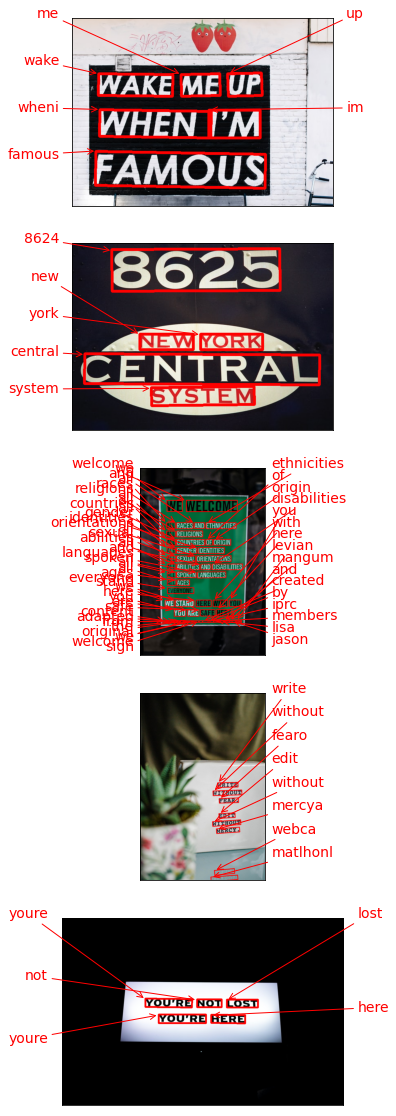

In [6]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 2. tesseract OCR

In [28]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/OCR1.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png


#### OCR1.jpg

In [29]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)


Done


#### OCR2.jpg

In [30]:
img_file_path = work_dir + '/OCR2.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
Sic pPbo.

>

eo a a

ae

=

CENTRAL

~we

mh SYSTEM

eee

Done


#### OCR3.jpg

In [31]:
img_file_path = work_dir + '/OCR3.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
nde aes

wa

)

Genie

it

|3

RELIGIONS

Oa aati

)F

ORIGIN

GENDER IDENTITIES

SEXUAL

ORIENTATIONS

Nees

AND

DISABILITIES

SPOKEN

| ANGU

#### OCR4.jpg

In [32]:
img_file_path = work_dir + '/OCR4.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
WRITE

WITHOUT

FEAR.

EDIT

WITHOUT

MERCY.

——ea


Done


#### OCR5.jpg

In [33]:
img_file_path = work_dir + '/OCR5.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
YOU'RE

NOT

LOST

YOU'RE

reer Ee.

| “you're Here

Done


### 3. Google OCR API(https://cloud.google.com/vision 이용)

#### OCR1.jpg

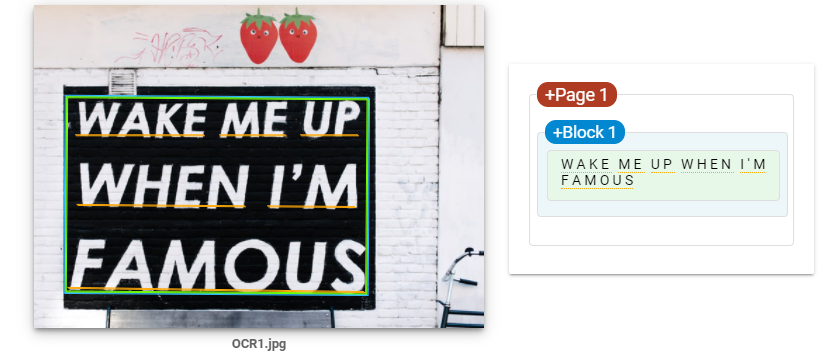

#### OCR2.jpg

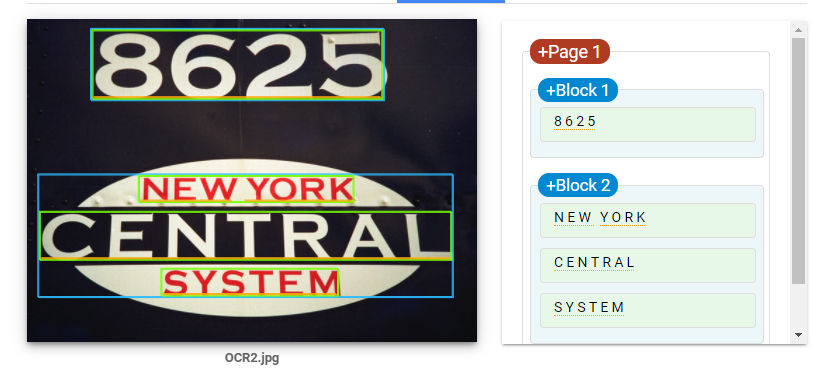

#### OCR3.jpg

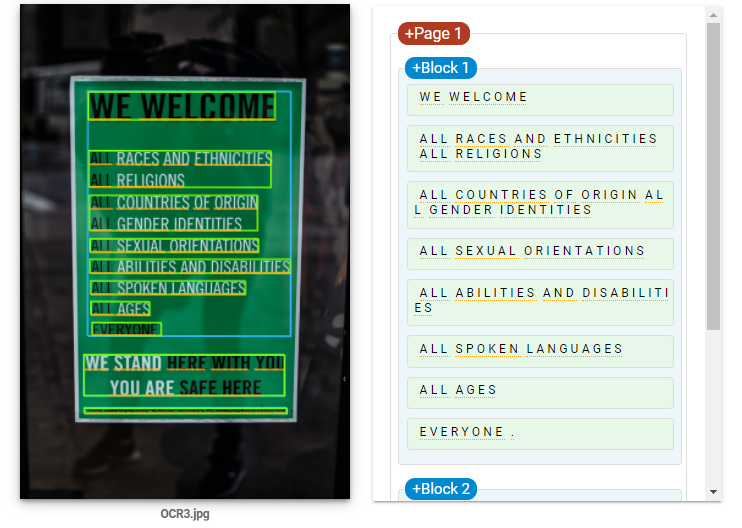

#### OCR4.jpg

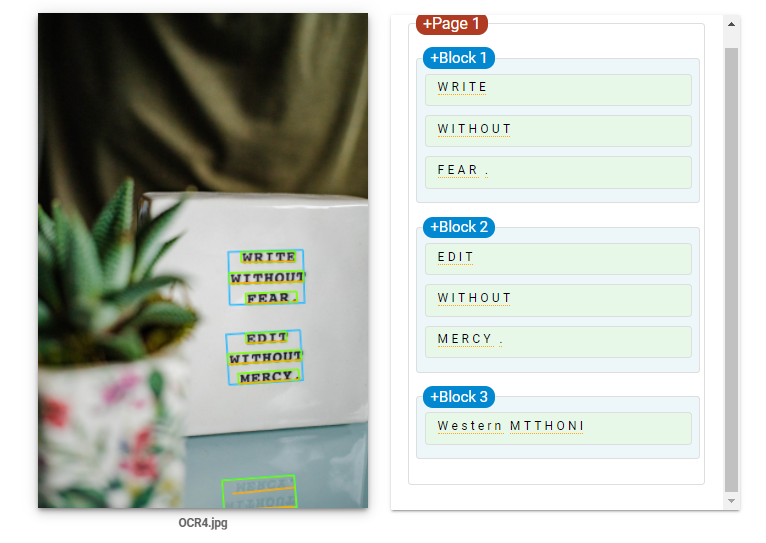

#### OCR5.jpg

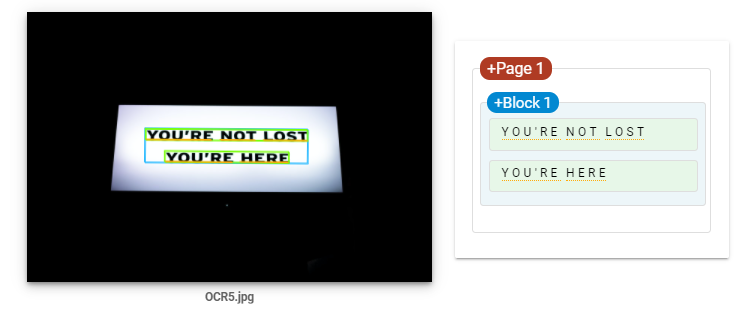

## 3) 테스트 결과 정리

### 1. OCR1.JPG

#### keras-ocr

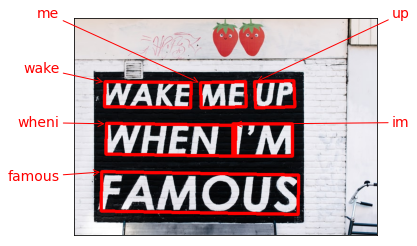

In [49]:
keras_ocr.tools.drawAnnotations(image=images[0], 
                                    predictions=prediction_groups[0][0])
plt.show()

#### Tesseract

In [50]:
img_file_path = work_dir + '/OCR1.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png

Done


#### Google OCR API

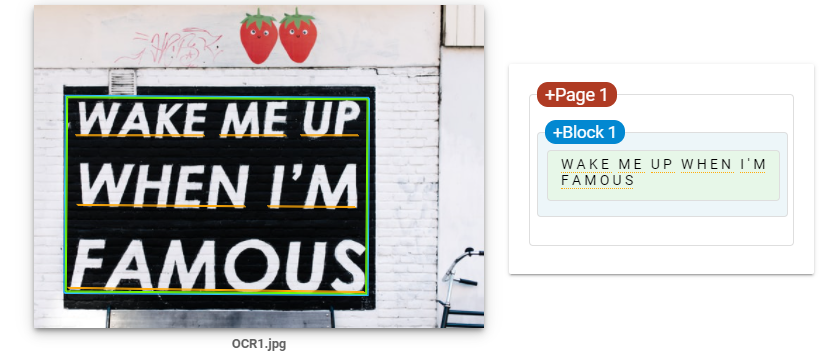

### 2. OCR2.JPG

#### keras-ocr

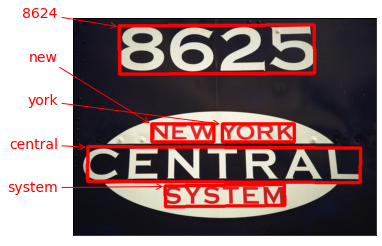

In [51]:
keras_ocr.tools.drawAnnotations(image=images[1], 
                                    predictions=prediction_groups[1][0])
plt.show()

#### Tesseract

In [52]:
img_file_path = work_dir + '/OCR2.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
Sic pPbo.

>

eo a a

ae

=

CENTRAL

~we

mh SYSTEM

eee

Done


#### Google OCR API

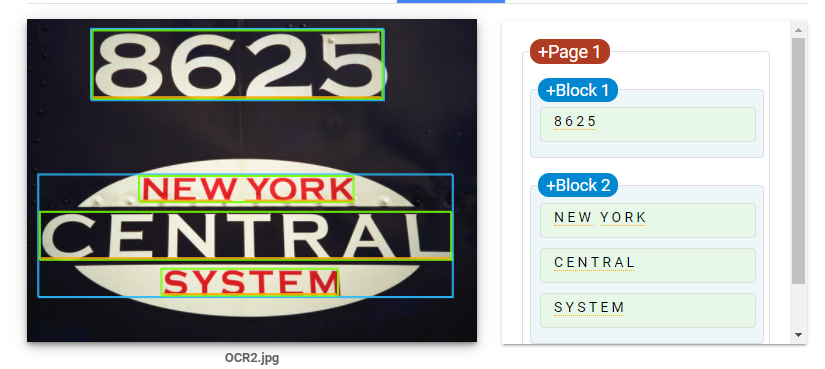

### 3. OCR3.JPG

#### keras-ocr

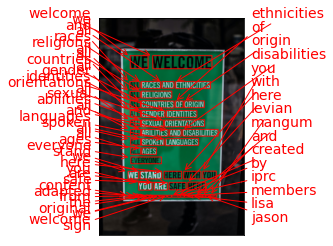

In [53]:
keras_ocr.tools.drawAnnotations(image=images[2], 
                                    predictions=prediction_groups[2][0])
plt.show()

#### Tesseract

In [54]:
img_file_path = work_dir + '/OCR3.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
/aiffel/aiffel/ocr_python/0008.png
/aiffel/aiffel/ocr_python/0009.png
/aiffel/aiffel/ocr_python/0010.png
/aiffel/aiffel/ocr_python/0011.png
/aiffel/aiffel/ocr_python/0012.png
/aiffel/aiffel/ocr_python/0013.png
/aiffel/aiffel/ocr_python/0014.png
/aiffel/aiffel/ocr_python/0015.png
/aiffel/aiffel/ocr_python/0016.png
/aiffel/aiffel/ocr_python/0017.png
/aiffel/aiffel/ocr_python/0018.png
/aiffel/aiffel/ocr_python/0019.png
/aiffel/aiffel/ocr_python/0020.png
/aiffel/aiffel/ocr_python/0021.png
/aiffel/aiffel/ocr_python/0022.png
/aiffel/aiffel/ocr_python/0023.png
nde aes

wa

)

Genie

it

|3

RELIGIONS

Oa aati

)F

ORIGIN

GENDER IDENTITIES

SEXUAL

ORIENTATIONS

Nees

AND

DISABILITIES

SPOKEN

| ANGU

#### Google OCR API

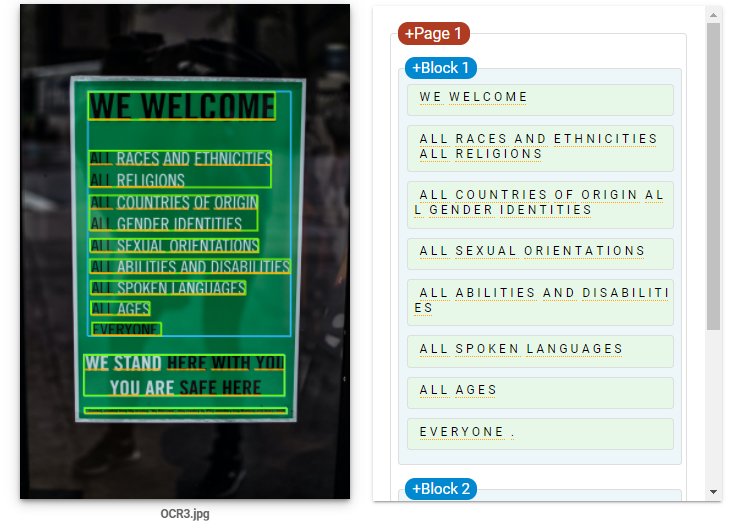

### 4. OCR4.JPG

#### keras-ocr

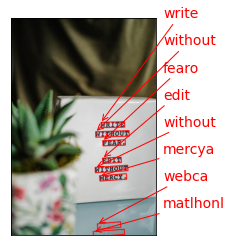

In [55]:
keras_ocr.tools.drawAnnotations(image=images[3], 
                                    predictions=prediction_groups[3][0])
plt.show()

#### Tesseract

In [56]:
img_file_path = work_dir + '/OCR4.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
/aiffel/aiffel/ocr_python/0006.png
/aiffel/aiffel/ocr_python/0007.png
WRITE

WITHOUT

FEAR.

EDIT

WITHOUT

MERCY.

——ea


Done


#### Google OCR API

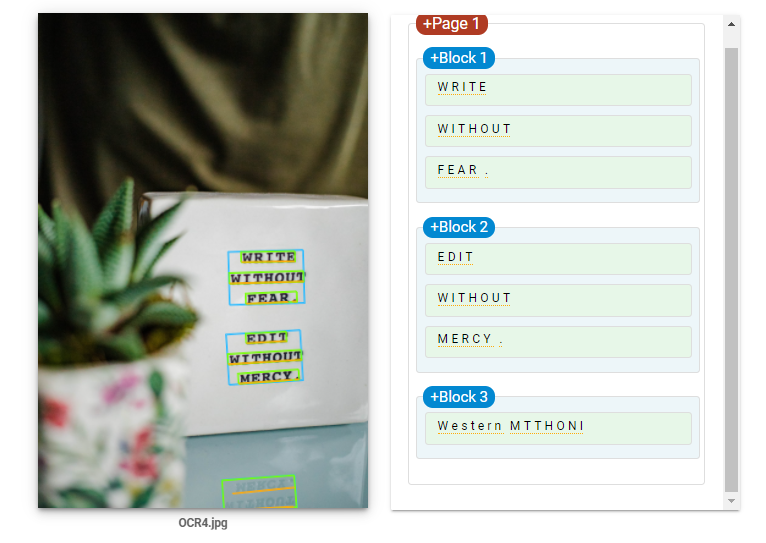

### 5. OCR5.JPG

#### keras-ocr

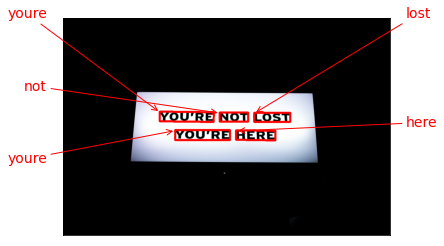

In [57]:
keras_ocr.tools.drawAnnotations(image=images[4], 
                                    predictions=prediction_groups[4][0])
plt.show()

#### Tesseract

In [58]:
img_file_path = work_dir + '/OCR5.jpg'
cropped_image_path_list = crop_word_regions(img_file_path, work_dir)
recognize_images(cropped_image_path_list)

/aiffel/aiffel/ocr_python/0000.png
/aiffel/aiffel/ocr_python/0001.png
/aiffel/aiffel/ocr_python/0002.png
/aiffel/aiffel/ocr_python/0003.png
/aiffel/aiffel/ocr_python/0004.png
/aiffel/aiffel/ocr_python/0005.png
YOU'RE

NOT

LOST

YOU'RE

reer Ee.

| “you're Here

Done


#### Google OCR API

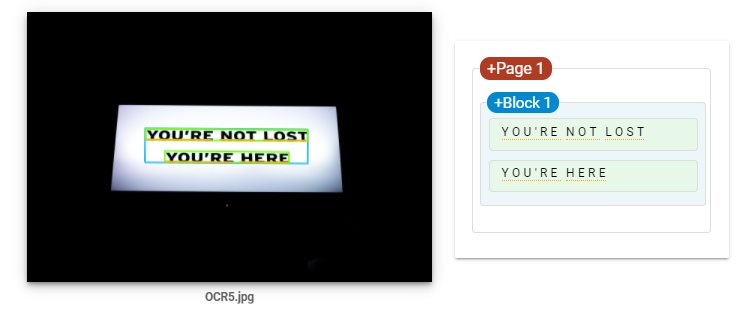

## 4) 결과 분석과 결론 제시

- 정확도 순으로 볼 때에는 google - keras - Tesseract이다. 
- OCR1.jpg를 보면 Tesseract는 아무것도 인식을 못한 것 같다. keras에서는 when 과 im이 겹쳐 wheni를 인식한 것으로 알 수 있다.
- 구글 Vision API는 깔끔하게 다 인식을 하는것 같도 keras도 나름 훌륭한 성능을 보이지만 몇몇 오타나, 다르게 인식하는 것을 알 수 있었다.
